In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost

from IPython.display import HTML

# local import
import nflplot
import nflutil
import nfl_bdb22

# ======== NOTEBOOK SETTINGS ====================
flag_run_modelsearch = False  # True = run CV search, False = use fixed parameters

# Import Data

In [3]:
game_df = pd.read_csv('csv/games.csv')
play_df = pd.read_csv('csv/plays.csv')

In [4]:
df_features = pd.read_csv('csv/model_features.csv', index_col=0)
df_features

,gameId,playId,frameId,timeToCatch,willReach,reachWithin5,reachWithin10,reachWithin20,reachWithin30,"('dist', 1)",...,"('willReachFactor', 1)","('willReachFactor', 2)","('willReachFactor', 3)","('willReachFactor', 4)","('willReachFactor', 5)",s_abs,s_dwnfld,s_lateral,distFromSideline,kickReturnYardage
0,2018123000,2502,32,4.3,0,0,0,2,2,47.408020,...,0.586348,0.665268,12.233350,8.597818,1.454067,0.44,-0.134725,0.418866,23.99,37.0
1,2018123000,2502,33,4.2,0,0,0,2,3,46.868126,...,0.532840,0.645667,10.031913,1.365108,7.267770,0.46,-0.184381,0.421430,24.03,37.0
2,2018123000,2502,34,4.1,0,0,0,2,3,46.327860,...,0.504591,0.631789,8.026933,1.295188,6.094832,0.49,-0.228454,0.433485,24.07,37.0
3,2018123000,2502,35,4.0,0,0,0,2,3,45.775811,...,0.490098,0.621178,6.416267,1.238533,5.127563,0.46,-0.283457,0.362287,24.11,37.0
4,2018123000,2502,36,3.9,0,0,0,2,3,45.206686,...,0.480391,0.604721,5.148187,1.158455,4.182153,0.43,-0.343774,0.258301,24.13,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95261,2020091401,3741,65,0.4,0,0,1,3,8,12.134249,...,2.189866,3.606979,5.711678,8.713081,27.972941,2.07,1.278117,1.628286,17.90,7.0
95262,2020091401,3741,66,0.3,0,0,1,3,8,11.207912,...,2.961793,4.888893,7.659962,11.672374,63.701856,1.76,1.042438,1.418070,18.05,7.0
95263,2020091401,3741,67,0.2,0,0,1,3,8,10.275549,...,4.500829,7.498705,11.537917,17.583457,197.525526,1.39,0.875886,1.079316,18.16,7.0
95264,2020091401,3741,68,0.1,0,0,1,3,8,9.335620,...,8.931511,15.454085,23.168291,35.950967,3209.803297,1.01,0.755159,0.670697,18.24,7.0


In [5]:
game_df.query('season == 2018')

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN
...,...,...,...,...,...,...,...
248,2018123011,2018,17,12/30/2018,20:20:00,TEN,IND
249,2018123012,2018,17,12/30/2018,16:25:00,WAS,PHI
250,2018123013,2018,17,12/30/2018,16:25:00,DEN,LAC
251,2018123014,2018,17,12/30/2018,16:25:00,LA,SF


In [6]:
(
    df_features
    .merge(game_df, how='inner', on='gameId')
    .filter(['season','week','gameId','playId'])
    .drop_duplicates()
    .groupby(['season','week'])
    .count()
    .reset_index()
)

,season,week,gameId,playId
0,2018,1,47,47
1,2018,2,51,51
2,2018,3,55,55
3,2018,4,48,48
4,2018,5,44,44
5,2018,6,42,42
6,2018,7,42,42
7,2018,8,44,44
8,2018,9,37,37
9,2018,10,34,34


In [7]:
df_features[['gameId','playId']].drop_duplicates().merge(game_df, how='inner', on='gameId').filter(['gameId','playId','week'])

,gameId,playId,week
0,2018123000,2502,17
1,2018123000,4148,17
2,2018123001,1326,17
3,2018123001,1538,17
4,2018123001,2289,17
...,...,...,...
2099,2020091401,394,1
2100,2020091401,1008,1
2101,2020091401,2267,1
2102,2020091401,2713,1


# Split data by week
Set the test set to be weeks 12-17 of 2020 so that all training data is earlier, to simulate the trained model being applied to future data.

In [8]:
weeks = range(9,18)
selected_games = game_df.loc[game_df.week.isin(weeks) & (game_df.season==2020), ['gameId','season','week']]
other_games = game_df.loc[~(game_df.week.isin(weeks) & (game_df.season==2020)), ['gameId','season','week']]

In [9]:
selected_games

,gameId,season,week
627,2020110500,2020,9
628,2020110800,2020,9
629,2020110801,2020,9
630,2020110802,2020,9
631,2020110803,2020,9
...,...,...,...
759,2021010311,2020,17
760,2021010312,2020,17
761,2021010313,2020,17
762,2021010314,2020,17


In [10]:
# data for selected weeks - test set (future data)
model_test_df = df_features.loc[df_features.gameId.isin(selected_games.gameId)]
X_test = model_test_df.drop(columns='kickReturnYardage')
Y_test = model_test_df[['gameId', 'playId', 'frameId', 'kickReturnYardage']]

In [11]:
# remaining records
model_df = df_features.loc[df_features.gameId.isin(other_games['gameId']), :]#.merge(other_games['gameId'], how='inner',on='gameId') #, indicator='i') #.query('week.isna()').drop(columns=['week','i'])
len(model_df)

78411

# Split training data by play
Prevent data leakage by not training on the same plays that are in the validation set. Since each record is at the frame level, data between frames in a play will be highly correlated and will likely overfit the model.

In [12]:
# training_plays_df = (
# other_games
# .merge(play_df[['gameId','playId']], how='inner', on='gameId')
# .merge(model_df[['gameId','playId']].drop_duplicates(), how='inner', on=['gameId','playId'])
# )

# plays_train, plays_val = train_test_split(training_plays_df, test_size=0.2, random_state=42)

# print(f'plays_train: {len(plays_train)}')
# print(f'plays_val: {len(plays_val)}')

In [13]:
# # get data related to plays
# model_train_df = model_df.merge(plays_train[['gameId','playId']], how='inner', on=['gameId','playId'])
# model_val_df = model_df.merge(plays_val[['gameId','playId']], how='inner', on=['gameId','playId'])

# X_train = model_train_df.drop(columns='kickReturnYardage')
# Y_train = model_train_df[['gameId','playId','frameId','kickReturnYardage']]
# X_val = model_val_df.drop(columns='kickReturnYardage')
# Y_val = model_val_df[['gameId','playId','frameId','kickReturnYardage']]
# X_cv = model_df.drop(columns='kickReturnYardage')
# Y_cv = model_df[['gameId','playId','frameId','kickReturnYardage']]

X_train = model_df.drop(columns='kickReturnYardage')
Y_train = model_df[['gameId','playId','frameId','kickReturnYardage']]

# Modeling

In [14]:
#%%timeit
model = xgboost.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X_train.drop(columns=['gameId','playId','frameId']), Y_train.drop(columns=['gameId','playId','frameId']));

In [15]:
#feature importances
pd.DataFrame({'columns': X_train.drop(columns=['gameId','playId','frameId']).columns, 'imp':model.feature_importances_}).sort_values(by='imp', ascending=False)

,columns,imp
3,reachWithin10,0.081024
2,reachWithin5,0.057811
4,reachWithin20,0.055322
10,"('dist', 5)",0.046081
27,s_dwnfld,0.043966
5,reachWithin30,0.039922
11,"('timeToClose', 1)",0.037299
16,"('upGutLeverage', 1)",0.034058
12,"('timeToClose', 2)",0.033442
29,distFromSideline,0.033089


**Create group labels for cross validation**

In [16]:
from sklearn.model_selection import GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import scipy.stats as stats

In [17]:
X_train_cv = X_train.assign(group=lambda x: list(zip(x.gameId, x.playId))).assign(cvgroup=lambda x: x.groupby('group').ngroup())

In [18]:
search_params = {
    'n_estimators': range(200, 401, 10),
    'max_depth': range(1, 7),
    'learning_rate': [.01, .05, .1, .2, .3]
}

### Create model

In [19]:
# data
X=X_train_cv.drop(columns=['gameId','playId','frameId','group','cvgroup'])
y=Y_train.kickReturnYardage
groups=X_train_cv.cvgroup

# train model
if flag_run_modelsearch:
    model = xgboost.XGBRegressor(random_state=np.random.RandomState(0), n_jobs=1, objective='reg:squarederror')
    rcv = RandomizedSearchCV(model, 
                            param_distributions=search_params, 
                            n_iter=50, 
                            scoring="neg_mean_squared_error", 
                            n_jobs=8, 
                            cv=GroupKFold(n_splits=5), 
                            random_state=42)

    search_model = rcv.fit(X=X,
                        y=y,
                        groups=groups)
    end_model = search_model.best_estimator_
    
    print(search_model.best_params_)

else: # fixed parameters
    best_params = {'random_state': np.random.RandomState(0), 
                   'n_jobs': 8, 
                   'objective': 'reg:squarederror', 
                   'n_estimators': 280, 
                   'max_depth': 4, 
                   'learning_rate': 0.01
                   }
    end_model = xgboost.XGBRegressor(**best_params).fit(X=X, y=y)

In [20]:
mae = mean_absolute_error(y, end_model.predict(X=X))
r2 = r2_score(y, end_model.predict(X=X))

print(f'MAE: {mae}')
print(f'R2: {r2}')

MAE: 6.128697182278637
R2: 0.09751989809951045


In [21]:
pd.DataFrame({'columns': X.columns, 'imp':end_model.feature_importances_}).sort_values(by='imp', ascending=False)

,columns,imp
4,reachWithin20,0.105049
3,reachWithin10,0.068636
10,"('dist', 5)",0.055694
13,"('timeToClose', 3)",0.044130
27,s_dwnfld,0.043599
2,reachWithin5,0.043115
24,"('willReachFactor', 4)",0.038000
8,"('dist', 3)",0.036984
0,timeToCatch,0.033819
21,"('willReachFactor', 1)",0.033621


## Save model

In [22]:
with open('yd_predict_model.pickle', 'wb') as file:
    pickle.dump(end_model, file)

# Evaluate Test set

In [23]:
y_test_pred = end_model.predict(X=X_test.drop(columns=['gameId','playId','frameId']))

In [24]:
mae = mean_absolute_error(Y_test['kickReturnYardage'], end_model.predict(X=X_test.drop(columns=['gameId','playId','frameId'])))
r2 = r2_score(Y_test['kickReturnYardage'], end_model.predict(X=X_test.drop(columns=['gameId','playId','frameId'])))

print(f'MAE: {mae}')
print(f'R2: {r2}')

MAE: 6.652370838353698
R2: 0.017642058468893218


In [25]:
Y_test_w_pred = Y_test.copy()
Y_test_w_pred['kickReturnYardage_pred'] = y_test_pred
Y_test_w_pred['diff'] = Y_test_w_pred.kickReturnYardage_pred - Y_test_w_pred.kickReturnYardage
Y_test_w_pred['yardGroup'] = pd.cut(Y_test_w_pred.kickReturnYardage, bins=[-10,0,5,10,20,30,100], right=False)
Y_test_w_pred['timeToCatch'] = (
        # catch frame for the play
        Y_test_w_pred.merge(Y_test_w_pred.groupby(['gameId','playId'])['frameId'].max().rename('catch_frame'), how='inner', on=['gameId','playId'])['catch_frame'].to_numpy()
        -
        Y_test_w_pred['frameId'].to_numpy()
) / 10 # convert to seconds

In [26]:
Y_test_w_pred.describe()

,gameId,playId,frameId,kickReturnYardage,kickReturnYardage_pred,diff,timeToCatch
count,1.685500e+04,16855.000000,16855.000000,16855.000000,16855.000000,16855.000000,16855.000000
mean,2.020215e+09,1878.117591,55.053515,9.321388,8.284726,-1.036662,2.252685
std,2.792014e+05,1222.430452,13.676273,11.943217,2.239389,11.791914,1.356124
min,2.020110e+09,116.000000,16.000000,-8.000000,1.514314,-81.716092,0.000000
25%,2.020112e+09,758.000000,43.000000,2.000000,6.998470,-3.937387,1.100000
50%,2.020121e+09,1827.000000,55.000000,7.000000,8.266894,0.969898,2.200000
75%,2.020122e+09,2891.000000,66.000000,12.000000,9.566391,5.208144,3.400000
max,2.021010e+09,4746.000000,91.000000,91.000000,47.527416,38.527416,5.800000


<Axes: xlabel='yardGroup', ylabel='kickReturnYardage_pred'>

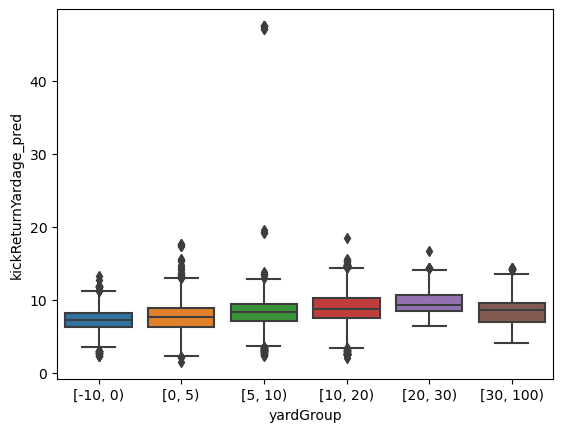

In [27]:
sns.boxplot(data=Y_test_w_pred, x='yardGroup',y='kickReturnYardage_pred')

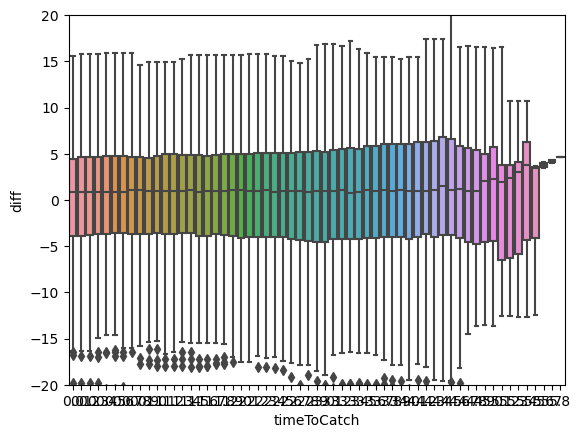

In [28]:
ax = sns.boxplot(data=Y_test_w_pred, x='timeToCatch',y='diff')
ax.set_ylim([-20, 20]);

In [29]:
Y_test_w_pred.groupby('yardGroup')['kickReturnYardage_pred'].describe()

,count,mean,std,min,25%,50%,75%,max
yardGroup,,,,,,,,
"[-10, 0)",867.0,7.232362,1.669125,2.286297,6.250092,7.293743,8.219836,13.348045
"[0, 5)",5025.0,7.659052,2.092506,1.514314,6.262987,7.635194,8.961595,17.695662
"[5, 10)",4490.0,8.289993,2.490456,2.377049,7.086831,8.282451,9.423591,47.527416
"[10, 20)",5028.0,8.831304,2.095666,2.106885,7.527450,8.728386,10.294165,18.425571
"[20, 30)",905.0,9.570663,1.484276,6.402995,8.436205,9.312630,10.723904,16.650169
"[30, 100)",540.0,8.508404,2.040901,4.082772,6.949163,8.563547,9.593114,14.362317


Left off: the prediction is not actually very good for 0-5 yards where most returns end up. Tends to predict near the average with low variance - 50% of predictions are 8-9.6 yards.

Test new features:
* **n_will_reach**: count(defender_TimeToReturner - timeToCatch < 0)
* **willReachFactor_defenderI**: (defender_TimeToReturner - timeToCatch) / max(timeToCatch, 0.1)  -- normalized measure for reaching returner. More negative = more certainty to reach returner. Higher magnitude as time to catch gets closer (proxy for higher certainty and higher impact on the play result)

# Validation Curves

In [30]:
from sklearn.model_selection import validation_curve

val_xgb_params = end_model.get_xgb_params()
del val_xgb_params['max_depth']
max_depth_range = range(1,11)

gkf_cv = list(GroupKFold(n_splits=5).split(X=X, y=y, groups=X_train_cv.cvgroup))
train_scores, test_scores = validation_curve(
    xgboost.XGBRegressor(**val_xgb_params),
    X,
    y,
    cv=gkf_cv,
    param_name='max_depth',
    param_range=max_depth_range,
    scoring="neg_mean_squared_error",
    n_jobs=1
)


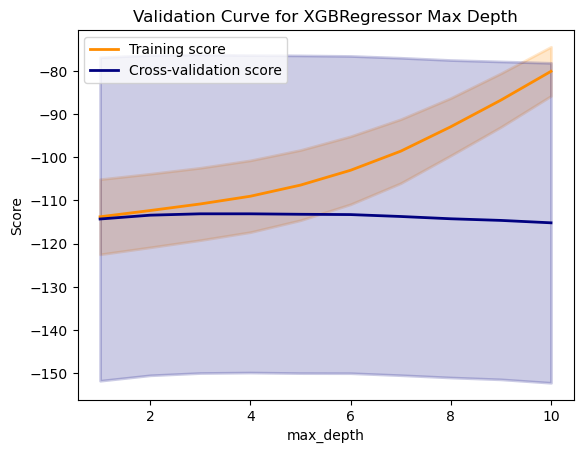

In [31]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve for XGBRegressor Max Depth")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    max_depth_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    max_depth_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    max_depth_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    max_depth_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

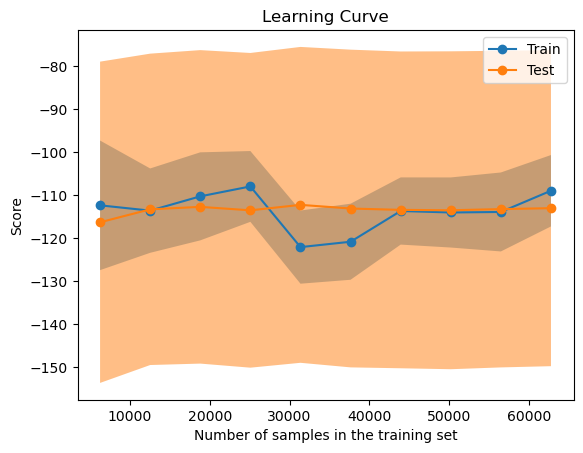

In [32]:
from sklearn.model_selection import LearningCurveDisplay

f, ax = plt.subplots()

LearningCurveDisplay.from_estimator(
    xgboost.XGBRegressor(**end_model.get_xgb_params()),
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=gkf_cv,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    line_kw={"marker": "o"},
    std_display_style="fill_between",
    score_type='both',
    ax=ax
)

ax.legend(['Train','Test'])
ax.set_title('Learning Curve');